# Modelisation de clustering

Ce notebook renferme les essais des différentes approches de modélisation pour segmenter nos données.

In [36]:
def plot_univarie(df, list_col, cust_bin=20):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        # mesures de tendances centrales
        print("moyenne : ", df[col].mean())
        print("médiane : ", df[col].median())
        print("mode : ", df[col].mode())
        print("min : ", df[col].min())
        print("max : ", df[col].max())
        quartiles = [np.percentile(df[col], p) for p in [25, 75]]
        print("quartiles : ", quartiles)
        # mesures de dispersion
        print("variance : ", df[col].var(ddof=0))
        print("écart-type : ", df[col].std(ddof=0))
        print("coefficient de variation : ", df[col].std(ddof=0)/df[col].mean())
        # mesures de forme
        print("skewness : ", df[col].skew())
        print("kurtosis : ", df[col].kurtosis())
        df[col].hist(bins=cust_bin)
        plt.xlabel(col)
        # pour tracer les 1er et 3ème quartiles
        min_ylim, max_ylim = plt.ylim()
        # plt.xticks(np.arange(-15, 41, 5))
        plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
        plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
        plt.show()
        print("-"*70)

In [37]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df, silent=False):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64', 'int32'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64[ns]':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    if not silent:
        print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        if not silent:
            print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

## Chargement des données

In [38]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
sns.set()

On commence par charger le dataset d'étude préparé dans le notebook d'analyse exploratoire.

In [39]:
parse_date_col = [
    "review_creation_date",
    "review_answer_timestamp",
    "shipping_limit_date",
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date']
data = pd.read_csv("master_dataset.csv", encoding='utf-8', sep='\t', index_col=0, parse_dates=parse_date_col)

In [40]:
data.shape

(106837, 38)

## Création des variables RFM

Commençons par créer les composantes de l'étude RFM : 
 - le nombre de jour depuis le dernier achat
 - le nombre d'achat fait durant une certaine période
 - le montant total dépensé durant une certaine période

In [41]:
# on passe la colonne de date d'achat de timestamp à datetime
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

In [42]:
# on récupère la dernière date du dataset pour la comparaison
last_purchase_date = data["order_purchase_timestamp"].max() + timedelta(days=1)
print("La dernière date de référence que nous prendrons est :", last_purchase_date)

La dernière date de référence que nous prendrons est : 2018-09-04 09:06:57


In [43]:
# on calcule le montant acheté par ligne
data['order_value_by_item'] = data['order_item_id'] * (data['price'] + data["freight_value"])

In [46]:
aggregation = {
    'order_purchase_timestamp': lambda x: (last_purchase_date - x.max()).days,
    'order_id': 'count',
    'order_value_by_item': 'sum'
}

In [47]:
data_process = data.groupby(['customer_unique_id']).agg(aggregation)
data_process.rename(
    columns={'order_purchase_timestamp': 'rfm_recency',
             'customer_id': 'rfm_frequency',
             'order_value_by_item': 'rfm_monetary'}, inplace=True)

In [48]:
data_process.head()

rfm_recency  order_id  rfm_monetary
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2          116         1        141.90
0000b849f77a49e4a4ce2b2a4ca5be3f          119         1         27.19
0000f46a3911fa3c0805444483337064          542         1         86.22
0000f6ccb0745a6a4b88665a16c9f078          326         1         43.62
0004aac84e0df4da2b147fca70cf8255          293         1        196.89

In [49]:
data_process.describe()

rfm_recency      order_id  rfm_monetary
count  94720.000000  94720.000000  94720.000000
mean     243.437817      1.127924    179.767623
std      153.163707      0.596188    279.317793
min        1.000000      1.000000     10.070000
25%      119.000000      1.000000     64.090000
50%      224.000000      1.000000    111.890000
75%      353.000000      1.000000    192.390000
max      729.000000     54.000000  13664.080000

In [13]:
filter_data = data_process.loc[data_process["rfm_frequency"] > 1, :]
print(filter_data.shape)
filter_data.head()

(8385, 3)


rfm_recency  rfm_frequency  rfm_monetary
customer_unique_id                                                        
00053a61a98854899e70ed204dd4bafe          187              2        573.00
000bfa1d2f1a41876493be685390d6d3          339              2         70.00
000de6019bb59f34c099a907c151d855          382              2        369.70
000e309254ab1fc5ba99dd469d36bdb4           70              2        119.80
000fbf0473c10fc1ab6f8d2d286ce20c           39              2        331.86

----------------------------------------------------------------------
Colonne : rfm_recency
moyenne :  245.0119260584377
médiane :  228.0
mode :  0    283
Name: rfm_recency, dtype: int64
min :  1
max :  729
quartiles :  [119.0, 355.0]
variance :  23170.119356874675
écart-type :  152.21734249708433
coefficient de variation :  0.6212650336897438
skewness :  0.4178282721832914
kurtosis :  -0.6832113665008737


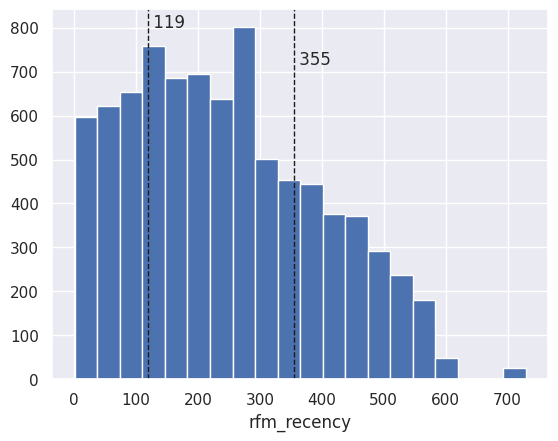

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : rfm_frequency
moyenne :  2.4450805008944543
médiane :  2.0
mode :  0    2
Name: rfm_frequency, dtype: int64
min :  2
max :  54
quartiles :  [2.0, 2.0]
variance :  2.1117423459346325
écart-type :  1.4531835210786808
coefficient de variation :  0.5943295202538649
skewness :  11.356444314549853
kurtosis :  256.13719197944687


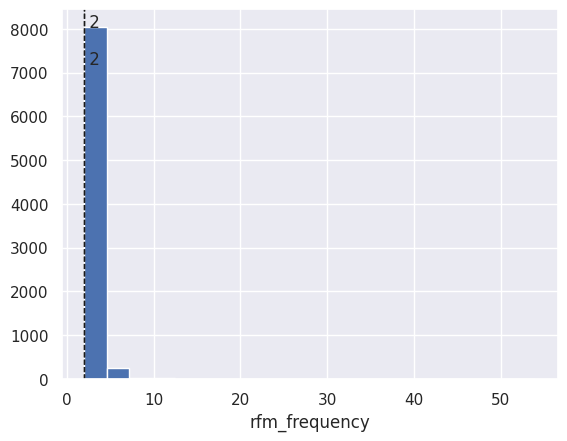

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : rfm_monetary
moyenne :  335.5121049493143
médiane :  207.59
mode :  0    119.8
1    139.8
Name: rfm_monetary, dtype: float64
min :  4.4
max :  11383.95
quartiles :  [115.98, 359.94]
variance :  278530.57709950476
écart-type :  527.759961629816
coefficient de variation :  1.572998272922357
skewness :  8.262847183519067
kurtosis :  109.3484923274494


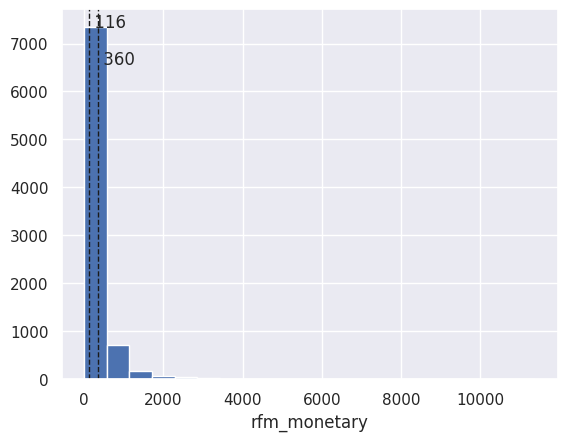

----------------------------------------------------------------------


In [14]:
plot_univarie(filter_data, filter_data.columns)

In [15]:
start = time.time()

In [16]:
# X = data[data_num.columns.to_list()].values
# temp_col = ["rfm_recency", "rfm_frequency", "rfm_monetary"]
X = filter_data.values
from sklearn import preprocessing
X_norm = preprocessing.scale(X)

In [17]:
# X_norm = X_norm.reshape(-1, 1)

In [18]:
# from sklearn import cluster, metrics

# silhouettes = []
# for num_clusters in range(2, 11):
#     cls = cluster.KMeans(
#         n_clusters=num_clusters,
#         init='k-means++')
#     cls.fit(X_norm)
#     silh = metrics.silhouette_score(X_norm, cls.labels_)
#     silhouettes.append(silh)

In [19]:
# plt.plot(range(2, 11), silhouettes, marker='o')

In [20]:
end = time.time()
delta = round(end - start, 0)
print("Execution time is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")

Execution time is: 0.0 s, soit 0.0 min, soit 0.0 h.


# yellowbrick

In [21]:
# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

In [22]:
# for n_clusters in [2, 3, 4, 5]:
#     cls = cluster.KMeans(n_clusters=n_clusters)
#     cls.fit(X_norm)
#     visualizer = InterclusterDistance(cls)
#     visualizer.fit(X)
#     visualizer.show()

In [23]:
from sklearn import preprocessing
from sklearn import decomposition

In [24]:
# for col in ["rfm_recency", "rfm_frequency", "rfm_monetary"]:
#     print("Colonne :", col)
#     X = data_process[col].values
#     X_norm = preprocessing.scale(X)
#     X_norm = X_norm.reshape(-1, 1)
#     cls = cluster.KMeans(n_clusters=3)
#     cls.fit(X_norm)
#     visualizer = InterclusterDistance(cls)
#     visualizer.fit(X)
#     visualizer.show()

# Scatter

[0.46798694 0.80110319]
2 clusters.


/home/slerendu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


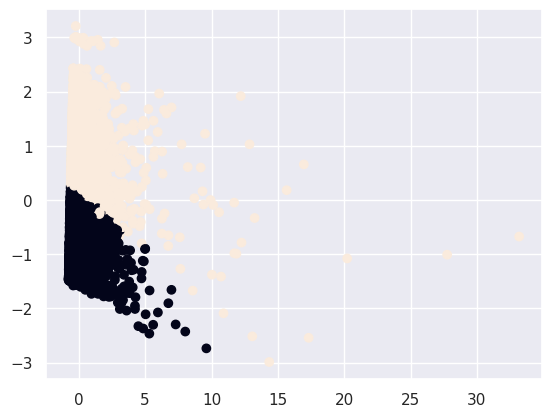

3 clusters.


/home/slerendu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


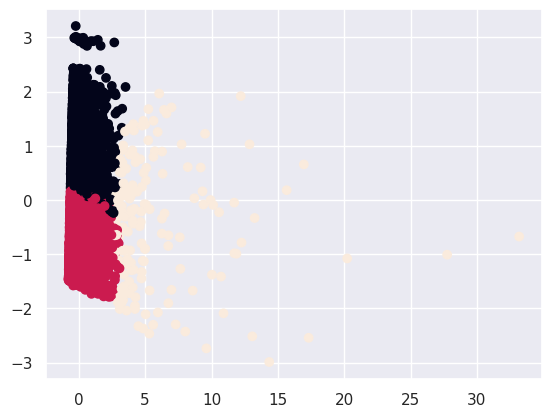

4 clusters.


/home/slerendu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


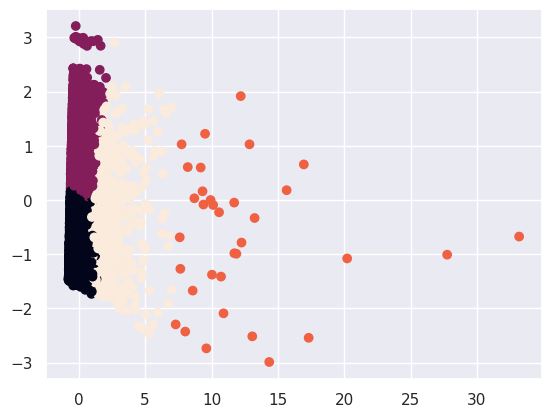

5 clusters.


/home/slerendu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


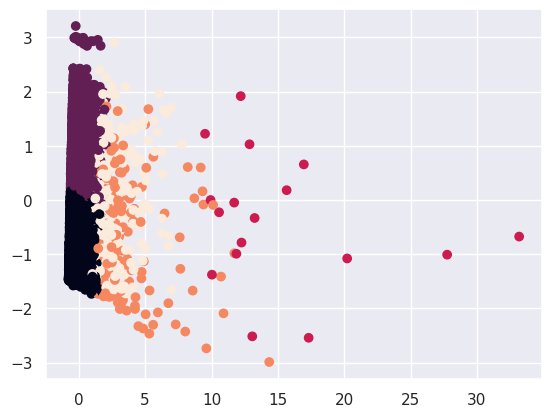

In [25]:
from sklearn import cluster, metrics

pca = decomposition.PCA(n_components=2)
pca.fit(X_norm)
print(pca.explained_variance_ratio_.cumsum())
X_trans = pca.transform(X_norm)

for n_clusters in [2, 3, 4, 5]:
    print(n_clusters, "clusters.")
    # X = data_process.values
    # X_norm = preprocessing.scale(X)
    
    # fig = plt.figure(figsize=(12, 5))

    cls2 = cluster.KMeans(n_clusters=n_clusters)
    cls2.fit(X_norm)
    # ax = fig.add_subplot(121)
    plt.scatter(X_trans[:, 0], X_trans[:, 1], c=cls2.labels_)
    plt.show()

    # cls3 = cluster.KMeans(n_clusters=3)
    # cls3.fit(X_norm)
    # ax = fig.add_subplot(122)
    # ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls3.labels_)

/home/slerendu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


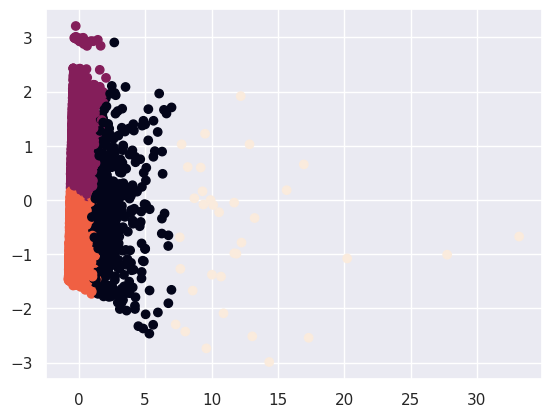

In [26]:
# pour 4 clusters
cls = cluster.KMeans(n_clusters=4)
cls.fit(X_norm)
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=cls.labels_)
plt.show()

In [27]:
cls.cluster_centers_

array([[-0.01575285,  1.59985401,  1.84181152],
       [ 0.96639951, -0.12524254, -0.17263711],
       [-0.73797588, -0.1570939 , -0.15658765],
       [ 0.50133317,  8.23480588,  9.14120057]])

In [28]:
filter_data.head()

rfm_recency  rfm_frequency  rfm_monetary
customer_unique_id                                                        
00053a61a98854899e70ed204dd4bafe          187              2        573.00
000bfa1d2f1a41876493be685390d6d3          339              2         70.00
000de6019bb59f34c099a907c151d855          382              2        369.70
000e309254ab1fc5ba99dd469d36bdb4           70              2        119.80
000fbf0473c10fc1ab6f8d2d286ce20c           39              2        331.86

In [29]:
cluster_map = pd.DataFrame()
cluster_map['customer_unique_id'] = filter_data.index.values
cluster_map['cluster'] = cls.labels_
cluster_map.head()

customer_unique_id  cluster
0  00053a61a98854899e70ed204dd4bafe        2
1  000bfa1d2f1a41876493be685390d6d3        1
2  000de6019bb59f34c099a907c151d855        1
3  000e309254ab1fc5ba99dd469d36bdb4        2
4  000fbf0473c10fc1ab6f8d2d286ce20c        2

In [30]:
data_w_cluster = pd.merge(data, cluster_map, on="customer_unique_id", how="inner")

In [31]:
data_w_cluster = pd.merge(data_w_cluster, filter_data, on="customer_unique_id", how="inner")

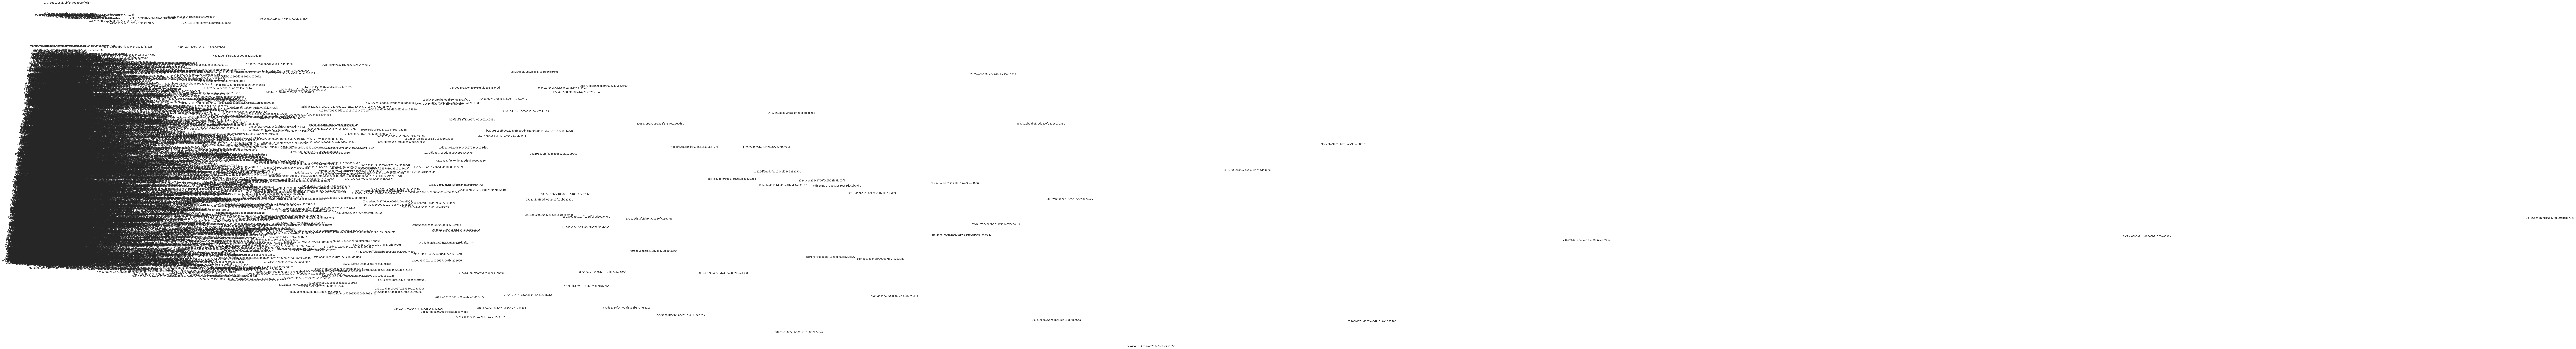

In [32]:

for i, (x, y) in enumerate(zip(X_trans[:, 0], X_trans[:, 1])):
    plt.text(x, y, filter_data.index[i])

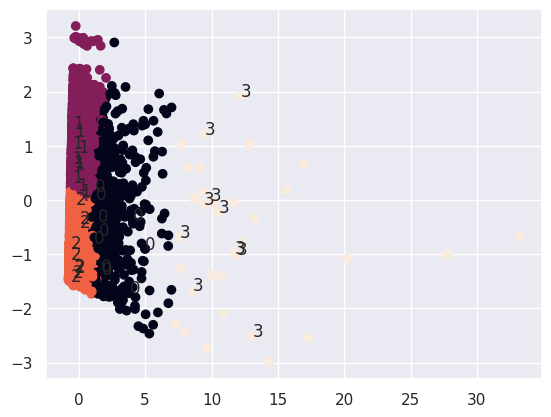

In [33]:
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=cls.labels_)
count = {
    0: 0,
    1: 0,
    2: 0,
    3: 0
}
for i, (x, y) in enumerate(zip(X_trans[:, 0], X_trans[:, 1])):
    temp_clust = cluster_map.iat[i, 1]
    if count[temp_clust] < 10:
        plt.text(x, y, temp_clust)
        count[temp_clust] += 1
plt.show()

In [34]:
data_num, data_categ, data_date = split_data_num_categ(data_w_cluster)

Voici la répartition des colonnes par type de données :
numeric : 22 colonnes.
category : 13 colonnes.
boolean : 0 colonnes.
datetime : 8 colonnes.
deltatime : 0 colonnes.


COLONNE : rfm_recency
CLUSTER : 2
----------------------------------------------------------------------
Colonne : rfm_recency
moyenne :  132.18228902203717
médiane :  133.0
mode :  0    201
Name: rfm_recency, dtype: int64
min :  1
max :  263
quartiles :  [70.0, 195.0]
variance :  5211.162566386253
écart-type :  72.18838248905604
coefficient de variation :  0.5461274957723038
skewness :  -0.008027491364832893
kurtosis :  -1.2021606234583904


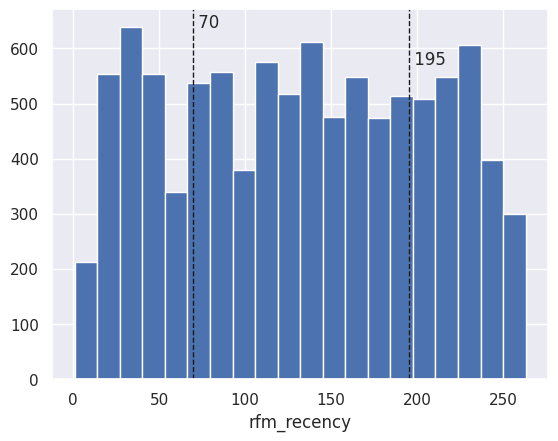

----------------------------------------------------------------------
CLUSTER : 1
----------------------------------------------------------------------
Colonne : rfm_recency
moyenne :  393.05276907001047
médiane :  379.0
mode :  0    283
Name: rfm_recency, dtype: int64
min :  260
max :  729
quartiles :  [308.0, 465.0]
variance :  9057.69731991846
écart-type :  95.17193556883488
coefficient de variation :  0.2421352628910824
skewness :  0.5669800357832826
kurtosis :  -0.43203322587727966


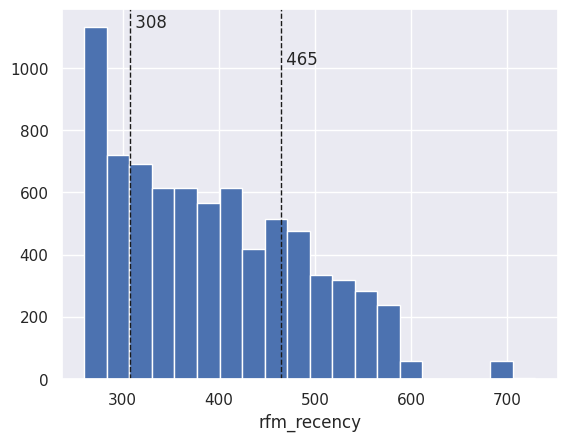

----------------------------------------------------------------------
CLUSTER : 0
----------------------------------------------------------------------
Colonne : rfm_recency
moyenne :  251.38341968911917
médiane :  238.0
mode :  0    283
Name: rfm_recency, dtype: int64
min :  10
max :  699
quartiles :  [132.0, 358.0]
variance :  21969.04868483821
écart-type :  148.21959615664255
coefficient de variation :  0.5896156410790447
skewness :  0.3866762705958689
kurtosis :  -0.5996498163421076


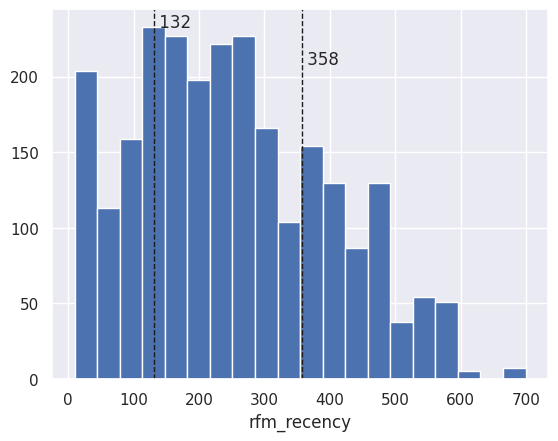

----------------------------------------------------------------------
CLUSTER : 3
----------------------------------------------------------------------
Colonne : rfm_recency
moyenne :  353.6020408163265
médiane :  391.0
mode :  0    391
Name: rfm_recency, dtype: int64
min :  23
max :  594
quartiles :  [269.0, 462.0]
variance :  20976.362036651393
écart-type :  144.83218577599177
coefficient de variation :  0.4095909215954519
skewness :  -0.442870177699356
kurtosis :  -0.6094293346932509


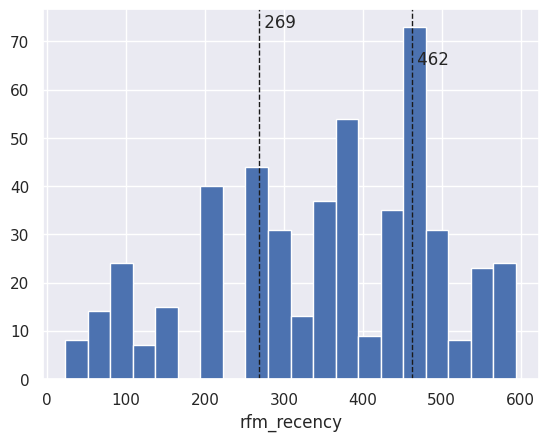

----------------------------------------------------------------------
COLONNE : rfm_frequency
CLUSTER : 2
----------------------------------------------------------------------
Colonne : rfm_frequency
moyenne :  2.34518127348431
médiane :  2.0
mode :  0    2
Name: rfm_frequency, dtype: int64
min :  2
max :  6
quartiles :  [2.0, 2.0]
variance :  0.45208986000069373
écart-type :  0.67237627858268
coefficient de variation :  0.2867054611875308
skewness :  2.0101867375967912
kurtosis :  3.571175831483396


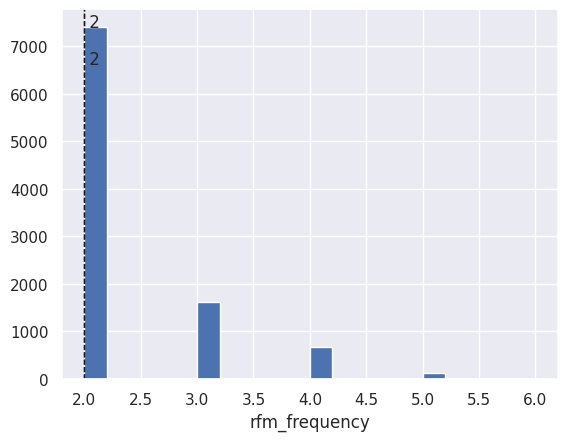

----------------------------------------------------------------------
CLUSTER : 1
----------------------------------------------------------------------
Colonne : rfm_frequency
moyenne :  2.4250261233019854
médiane :  2.0
mode :  0    2
Name: rfm_frequency, dtype: int64
min :  2
max :  6
quartiles :  [2.0, 3.0]
variance :  0.5933862323374267
écart-type :  0.770315670577606
coefficient de variation :  0.3176525247194954
skewness :  1.9325130963686779
kurtosis :  3.5589478686951144


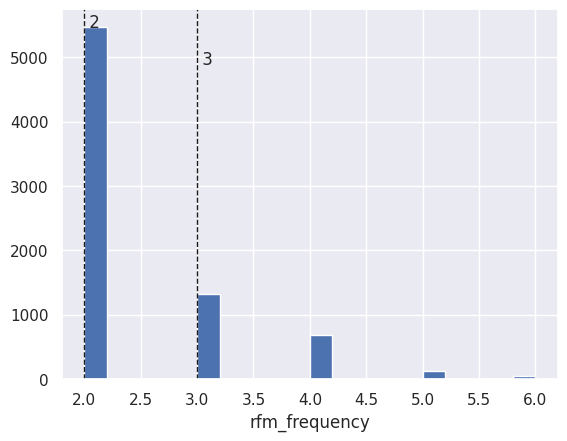

----------------------------------------------------------------------
CLUSTER : 0
----------------------------------------------------------------------
Colonne : rfm_frequency
moyenne :  6.154244719011558
médiane :  6.0
mode :  0    6
Name: rfm_frequency, dtype: int64
min :  2
max :  16
quartiles :  [4.0, 7.0]
variance :  9.00649951922779
écart-type :  3.0010830577023007
coefficient de variation :  0.4876444136892088
skewness :  0.9111394532894145
kurtosis :  0.5978811576477332


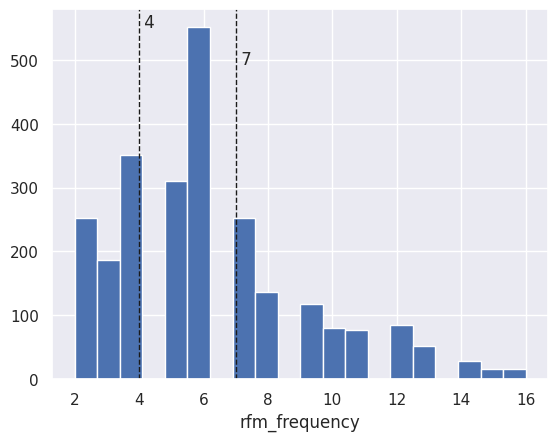

----------------------------------------------------------------------
CLUSTER : 3
----------------------------------------------------------------------
Colonne : rfm_frequency
moyenne :  21.910204081632653
médiane :  20.0
mode :  0    24
Name: rfm_frequency, dtype: int64
min :  2
max :  54
quartiles :  [13.0, 24.0]
variance :  170.5960183256976
écart-type :  13.061241071418046
coefficient de variation :  0.5961259430881932
skewness :  1.3328892953918685
kurtosis :  1.403606170527063


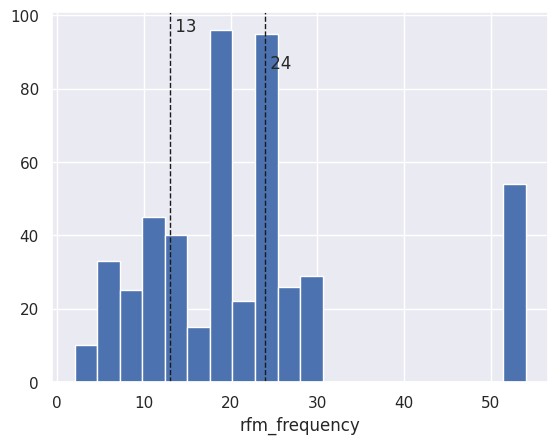

----------------------------------------------------------------------
COLONNE : rfm_monetary_y
CLUSTER : 2
----------------------------------------------------------------------
Colonne : rfm_monetary_y
moyenne :  258.49181171930536
médiane :  206.10000000000002
mode :  0    330.96
Name: rfm_monetary_y, dtype: float64
min :  4.4
max :  1398.0
quartiles :  [118.9, 330.975]
variance :  40178.98894665166
écart-type :  200.44697290468534
coefficient de variation :  0.7754480560581526
skewness :  1.825726913168833
kurtosis :  4.463035581631281


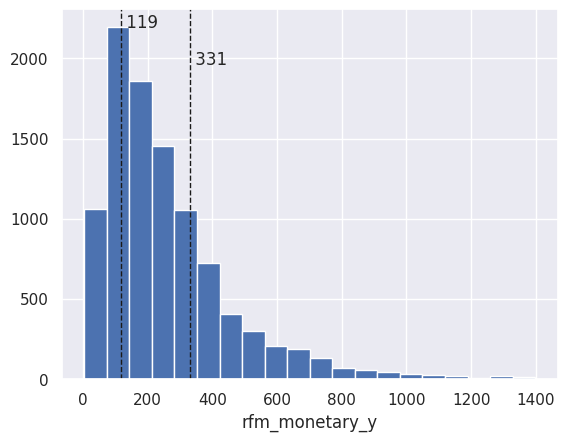

----------------------------------------------------------------------
CLUSTER : 1
----------------------------------------------------------------------
Colonne : rfm_monetary_y
moyenne :  250.89668495297806
médiane :  194.35
mode :  0    269.7
Name: rfm_monetary_y, dtype: float64
min :  8.4
max :  1520.0
quartiles :  [108.9925, 322.98]
variance :  40467.11748793941
écart-type :  201.16440412741866
coefficient de variation :  0.8017818336863239
skewness :  1.8308622655570146
kurtosis :  4.5381643067136626


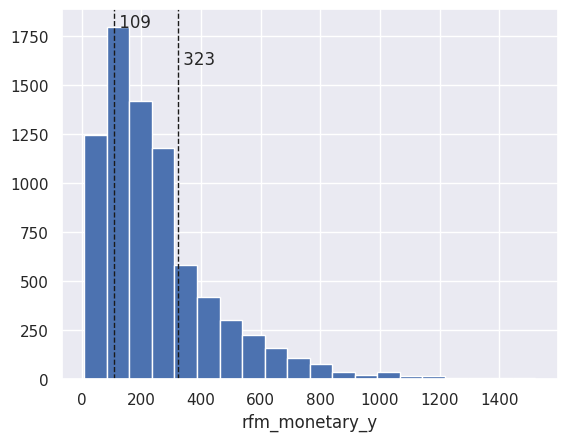

----------------------------------------------------------------------
CLUSTER : 0
----------------------------------------------------------------------
Colonne : rfm_monetary_y
moyenne :  1084.240725388601
médiane :  899.1
mode :  0    419.4
1    899.1
Name: rfm_monetary_y, dtype: float64
min :  101.39999999999999
max :  5298.0
quartiles :  [563.28, 1409.1]
variance :  567635.3751047747
écart-type :  753.4158049210109
coefficient de variation :  0.6948787176860381
skewness :  1.6738600569302897
kurtosis :  3.8978420747121914


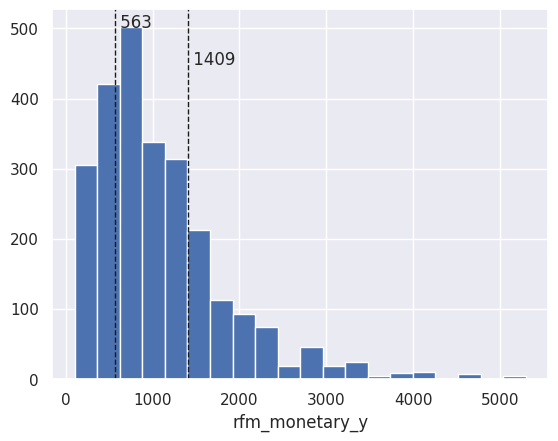

----------------------------------------------------------------------
CLUSTER : 3
----------------------------------------------------------------------
Colonne : rfm_monetary_y
moyenne :  4628.981142857142
médiane :  4149.4800000000005
mode :  0    6367.38
Name: rfm_monetary_y, dtype: float64
min :  638.0
max :  11383.95
quartiles :  [1848.8, 6367.379999999999]
variance :  9299867.656794615
écart-type :  3049.568437794865
coefficient de variation :  0.6587990626189033
skewness :  0.7608723779868868
kurtosis :  -0.2565597252970413


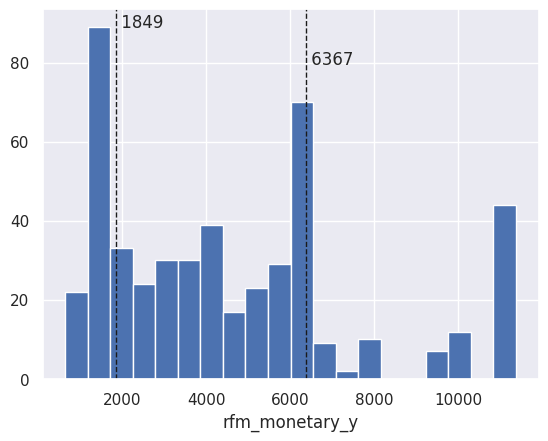

----------------------------------------------------------------------
COLONNE : order_item_id
CLUSTER : 2
----------------------------------------------------------------------
Colonne : order_item_id
moyenne :  1.3344165735757083
médiane :  1.0
mode :  0    1
Name: order_item_id, dtype: int64
min :  1
max :  12
quartiles :  [1.0, 1.0]
variance :  0.531102490425022
écart-type :  0.7287677890967891
coefficient de variation :  0.5461321475826546
skewness :  3.8843125745535434
kurtosis :  26.70752583013507


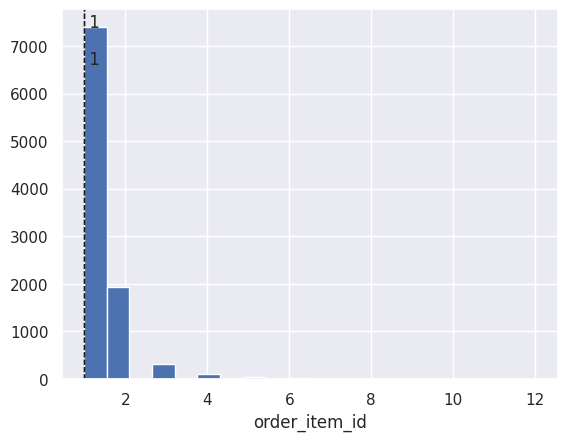

----------------------------------------------------------------------
CLUSTER : 1
----------------------------------------------------------------------
Colonne : order_item_id
moyenne :  1.3260188087774294
médiane :  1.0
mode :  0    1
Name: order_item_id, dtype: int64
min :  1
max :  21
quartiles :  [1.0, 1.0]
variance :  0.5585497718510367
écart-type :  0.7473618747641846
coefficient de variation :  0.5636133287228721
skewness :  6.894621844750016
kurtosis :  125.36020144999908


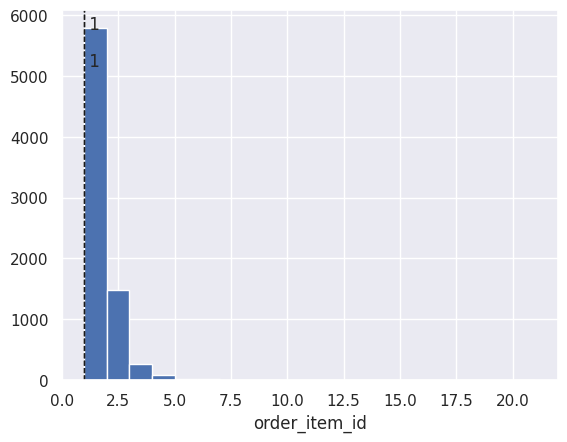

----------------------------------------------------------------------
CLUSTER : 0
----------------------------------------------------------------------
Colonne : order_item_id
moyenne :  1.5986448784376246
médiane :  1.0
mode :  0    1
Name: order_item_id, dtype: int64
min :  1
max :  15
quartiles :  [1.0, 2.0]
variance :  1.6121304872804654
écart-type :  1.2696970060925816
coefficient de variation :  0.7942333054814977
skewness :  3.477634137646111
kurtosis :  17.286227238328138


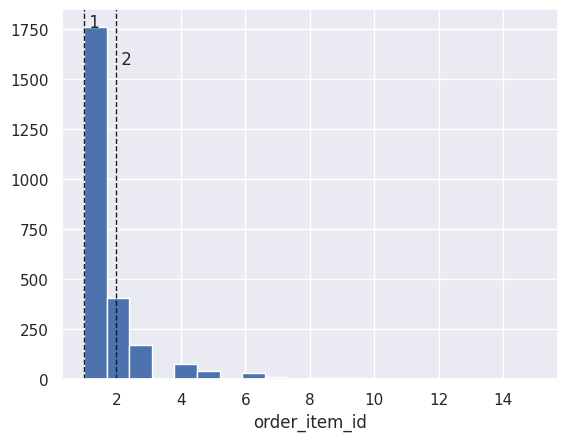

----------------------------------------------------------------------
CLUSTER : 3
----------------------------------------------------------------------
Colonne : order_item_id
moyenne :  1.6959183673469387
médiane :  1.0
mode :  0    1
Name: order_item_id, dtype: int64
min :  1
max :  11
quartiles :  [1.0, 2.0]
variance :  2.2238608912952937
écart-type :  1.4912615100294426
coefficient de variation :  0.8793238747466028
skewness :  3.5819207829815367
kurtosis :  15.071733538993463


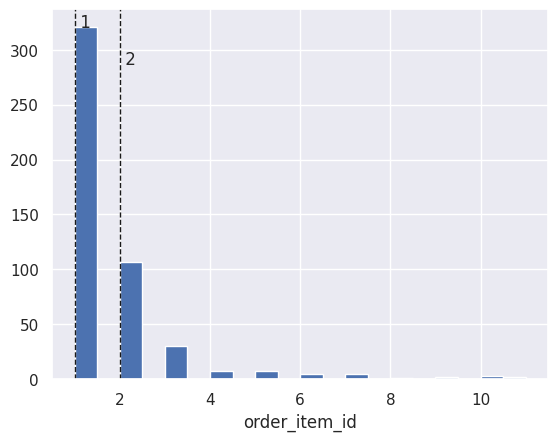

----------------------------------------------------------------------
COLONNE : price
CLUSTER : 2
----------------------------------------------------------------------
Colonne : price
moyenne :  91.3203767644968
médiane :  66.38
mode :  0    49.9
Name: price, dtype: float64
min :  0.85
max :  1199.0
quartiles :  [38.4, 114.9]
variance :  8012.257740459246
écart-type :  89.51121572439537
coefficient de variation :  0.9801888570305944
skewness :  3.513589791770893
kurtosis :  20.9573687100577


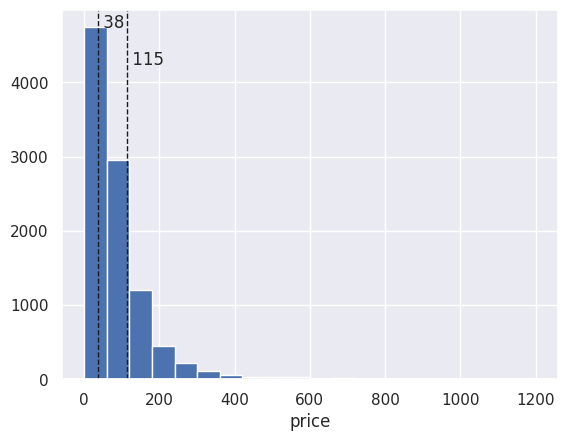

----------------------------------------------------------------------
CLUSTER : 1
----------------------------------------------------------------------
Colonne : price
moyenne :  86.59229885057472
médiane :  59.99
mode :  0    59.9
Name: price, dtype: float64
min :  1.2
max :  959.99
quartiles :  [34.99, 105.9]
variance :  6684.327357019361
écart-type :  81.75773576255253
coefficient de variation :  0.9441686714384981
skewness :  2.9968205992220796
kurtosis :  15.596375272688704


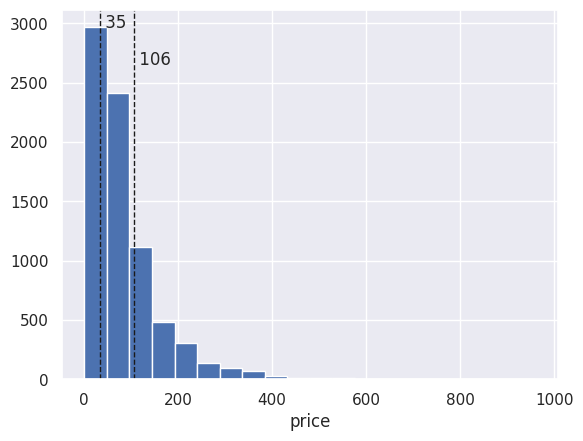

----------------------------------------------------------------------
CLUSTER : 0
----------------------------------------------------------------------
Colonne : price
moyenne :  201.0100438421682
médiane :  89.9
mode :  0    59.9
Name: price, dtype: float64
min :  3.85
max :  2649.0
quartiles :  [54.9, 189.9]
variance :  98250.27442411127
écart-type :  313.4489981226791
coefficient de variation :  1.5593698311353896
skewness :  3.55192118650164
kurtosis :  15.268157930919196


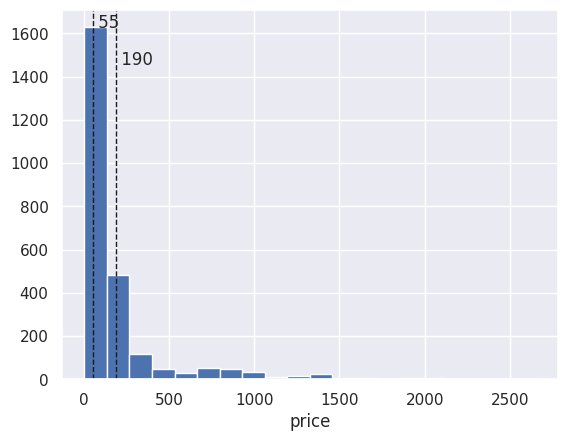

----------------------------------------------------------------------
CLUSTER : 3
----------------------------------------------------------------------
Colonne : price
moyenne :  288.13271428571426
médiane :  88.0
mode :  0    392.55
Name: price, dtype: float64
min :  12.99
max :  4799.0
quartiles :  [54.55, 392.55]
variance :  294542.6014683469
écart-type :  542.7177917374249
coefficient de variation :  1.8835688029484305
skewness :  4.830817912039285
kurtosis :  28.765909898843745


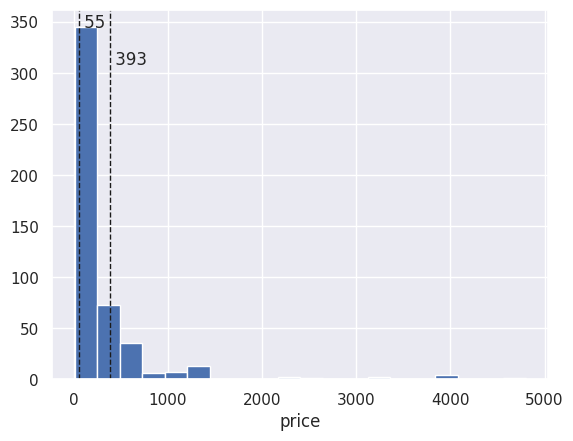

----------------------------------------------------------------------


In [35]:
col_to_process = ["rfm_recency", "rfm_frequency", "rfm_monetary_y", "order_item_id", "price"]
for col in col_to_process:
    print("COLONNE :", col)
    for num_clust in data_w_cluster["cluster"].unique():
        print("CLUSTER :", num_clust)
        temp_data = data_w_cluster.loc[data_w_cluster["cluster"] == num_clust, :]
        plot_univarie(temp_data, [col])